# Projeto Airbnb Rio - Ferramenta de Previsão de Preço de Imóvel para pessoas comuns 

### Contexto

No Airbnb, qualquer pessoa que tenha um quarto ou um imóvel de qualquer tipo (apartamento, casa, chalé, pousada, etc.) pode ofertar o seu imóvel para ser alugado por diária.

Você cria o seu perfil de host (pessoa que disponibiliza um imóvel para aluguel por diária) e cria o anúncio do seu imóvel.

Nesse anúncio, o host deve descrever as características do imóvel da forma mais completa possível, de forma a ajudar os locadores/viajantes a escolherem o melhor imóvel para eles (e de forma a tornar o seu anúncio mais atrativo)

Existem dezenas de personalizações possíveis no seu anúncio, desde quantidade mínima de diária, preço, quantidade de quartos, até regras de cancelamento, taxa extra para hóspedes extras, exigência de verificação de identidade do locador, etc.

### Nosso objetivo

Construir um modelo de previsão de preço que permita uma pessoa comum que possui um imóvel possa saber quanto deve cobrar pela diária do seu imóvel.

Ou ainda, para o locador comum, dado o imóvel que ele está buscando, ajudar a saber se aquele imóvel está com preço atrativo (abaixo da média para imóveis com as mesmas características) ou não.

### O que temos disponível, inspirações e créditos

As bases de dados foram retiradas do site kaggle: https://www.kaggle.com/allanbruno/airbnb-rio-de-janeiro

Elas estão disponíveis para download abaixo da aula (se você puxar os dados direto do Kaggle pode ser que encontre resultados diferentes dos meus, afinal as bases de dados podem ter sido atualizadas).

Caso queira uma outra solução, podemos olhar como referência a solução do usuário Allan Bruno do kaggle no Notebook: https://www.kaggle.com/allanbruno/helping-regular-people-price-listings-on-airbnb

Você vai perceber semelhanças entre a solução que vamos desenvolver aqui e a dele, mas também algumas diferenças significativas no processo de construção do projeto.

- As bases de dados são os preços dos imóveis obtidos e suas respectivas características em cada mês.
- Os preços são dados em reais (R$)
- Temos bases de abril de 2018 a maio de 2020, com exceção de junho de 2018 que não possui base de dados

### Expectativas Iniciais

- Acredito que a sazonalidade pode ser um fator importante, visto que meses como dezembro costumam ser bem caros no RJ
- A localização do imóvel deve fazer muita diferença no preço, já que no Rio de Janeiro a localização pode mudar completamente as características do lugar (segurança, beleza natural, pontos turísticos)
- Adicionais/Comodidades podem ter um impacto significativo, visto que temos muitos prédios e casas antigos no Rio de Janeiro

Vamos descobrir o quanto esses fatores impactam e se temos outros fatores não tão intuitivos que são extremamente importantes.

### Importar Bibliotecas e Bases de Dados

In [1]:
import pandas as pd
import pathlib
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
meses = {'jan': 1, 'fev': 2, 'mar': 3, 'abr': 4, 'mai': 5, 'jun': 6, 'jul': 7, 'ago': 8, 'set': 9, 'out': 10, 'nov': 11, 'dez': 12}
caminho_bases = pathlib.Path('dataset')

base_arbnb = pd.DataFrame()
for arquivo in caminho_bases.iterdir():
    nome_mes = arquivo.name[:3]
    mes = meses[nome_mes]

    ano = arquivo.name[-8:]
    ano = int(ano.replace('.csv', ''))
    df = pd.read_csv(caminho_bases / arquivo.name)
    df['ano'] = ano
    df['mes'] = mes
    
    base_arbnb = pd.concat([base_arbnb, df], ignore_index = True)
display(base_arbnb)

C:\Users\Mitsuya\AppData\Local\Temp\ipykernel_16828\1860417593.py:11: DtypeWarning: Columns (62,87) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(caminho_bases / arquivo.name)
C:\Users\Mitsuya\AppData\Local\Temp\ipykernel_16828\1860417593.py:11: DtypeWarning: Columns (61,62,94) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(caminho_bases / arquivo.name)
C:\Users\Mitsuya\AppData\Local\Temp\ipykernel_16828\1860417593.py:11: DtypeWarning: Columns (61,62,94) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(caminho_bases / arquivo.name)
C:\Users\Mitsuya\AppData\Local\Temp\ipykernel_16828\1860417593.py:11: DtypeWarning: Columns (87) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(caminho_bases / arquivo.name)
C:\Users\Mitsuya\AppData\Local\Temp\ipykernel_16828\1860417593.py:11: DtypeWarning: Columns (61,62,94) ha

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,number_of_reviews_ltm,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms
0,14063,https://www.airbnb.com/rooms/14063,20180414160018,2018-04-14,Living in a Postcard,"Besides the most iconic's view, our apartment ...",NaN,"Besides the most iconic's view, our apartment ...",none,Best and favorite neighborhood of Rio. Perfect...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,17878,https://www.airbnb.com/rooms/17878,20180414160018,2018-04-14,Very Nice 2Br - Copacabana - WiFi,Please note that special rates apply for New Y...,- large balcony which looks out on pedestrian ...,Please note that special rates apply for New Y...,none,This is the best spot in Rio. Everything happe...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,24480,https://www.airbnb.com/rooms/24480,20180414160018,2018-04-14,Nice and cozy near Ipanema Beach,My studio is located in the best of Ipanema. ...,The studio is located at Vinicius de Moraes St...,My studio is located in the best of Ipanema. ...,none,"The beach, the lagoon, Ipanema is a great loca...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,25026,https://www.airbnb.com/rooms/25026,20180414160018,2018-04-14,Beautiful Modern Decorated Studio in Copa,"Our apartment is a little gem, everyone loves ...",This newly renovated studio (last renovations ...,"Our apartment is a little gem, everyone loves ...",none,Copacabana is a lively neighborhood and the ap...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,31560,https://www.airbnb.com/rooms/31560,20180414160018,2018-04-14,NICE & COZY 1BDR - IPANEMA BEACH,This nice and clean 1 bedroom apartment is loc...,This nice and clean 1 bedroom apartment is loc...,This nice and clean 1 bedroom apartment is loc...,none,Die Nachbarschaft von Ipanema ist super lebend...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
902205,38844730,https://www.airbnb.com/rooms/38844730,20190923212307,2019-09-24,TRANSAMERICA BARRA DA TIJUCA R IV,"Em estilo contemporâneo, o Transamerica Prime ...",NaN,"Em estilo contemporâneo, o Transamerica Prime ...",none,NaN,...,1.0,1.0,1125.0,1125.0,1.0,1125.0,0.0,15.0,0.0,0.0
902206,38846408,https://www.airbnb.com/rooms/38846408,20190923212307,2019-09-24,Alugo para o Rock in Rio,"Confortável apartamento, 2 quartos , sendo 1 s...",O apartamento estará com mobília completa disp...,"Confortável apartamento, 2 quartos , sendo 1 s...",none,"Muito próximo ao Parque Olímpico, local do eve...",...,2.0,2.0,1125.0,1125.0,2.0,1125.0,0.0,1.0,0.0,0.0
902207,38846703,https://www.airbnb.com/rooms/38846703,20190923212307,2019-09-24,Apt COMPLETO em COPACABANA c/TOTAL SEGURANÇA,Apartamento quarto e sala COMPLETO para curtas...,Espaço ideal para até 5 pessoas. Cama de casal...,Apartamento quarto e sala COMPLETO para curtas...,none,NaN,...,3.0,3.0,1125.0,1125.0,3.0,1125.0,0.0,23.0,6.0,0.0
902208,38847050,https://www.airbnb.com/rooms/38847050,20190923212307,2019-09-24,Cobertura Cinematografica,Cobertura alto nivel,NaN,Cobertura alto nivel,none,NaN,...,1.0,1.0,1125.0,1125.0,1.0,1125.0,0.0,1.0,0.0,0.0


In [5]:
base_arbnb.head(1000).to_csv('primeiros_registros.csv', sep = ';')

### Consolidar Base de Dados

In [3]:
colunas = pd.read_csv('primeiros_registros.csv', sep = ';').columns

In [4]:
base_arbnb = base_arbnb.loc[:,colunas]

### Tratar Valores Faltando

In [5]:
print(base_arbnb.isnull().sum())

host_response_time             401843
host_response_rate             401846
host_is_superhost                 460
host_listings_count               460
latitude                            0
longitude                           0
property_type                       0
room_type                           0
accommodates                        0
bathrooms                        1724
bedrooms                          850
beds                             2502
bed_type                            0
amenities                           0
price                               0
security_deposit               421280
cleaning_fee                   313506
guests_included                     0
extra_people                        0
minimum_nights                      0
maximum_nights                      0
number_of_reviews                   0
review_scores_rating           448016
review_scores_accuracy         448586
review_scores_cleanliness      448413
review_scores_checkin          448650
review_score

- Excluir todas as colunas com valor NaN acima de 300000

In [6]:
for coluna in base_arbnb:
    if base_arbnb[coluna].isnull().sum() > 300000:
        base_arbnb = base_arbnb.drop(coluna, axis = 1)

print(base_arbnb.isnull().sum())

host_is_superhost            460
host_listings_count          460
latitude                       0
longitude                      0
property_type                  0
room_type                      0
accommodates                   0
bathrooms                   1724
bedrooms                     850
beds                        2502
bed_type                       0
amenities                      0
price                          0
guests_included                0
extra_people                   0
minimum_nights                 0
maximum_nights                 0
number_of_reviews              0
instant_bookable               0
is_business_travel_ready       0
cancellation_policy            0
ano                            0
mes                            0
dtype: int64


In [12]:
base_arbnb = base_arbnb.dropna()
print(base_arbnb.isnull().sum())

host_is_superhost           0
host_listings_count         0
latitude                    0
longitude                   0
property_type               0
room_type                   0
accommodates                0
bathrooms                   0
bedrooms                    0
beds                        0
bed_type                    0
amenities                   0
price                       0
guests_included             0
extra_people                0
minimum_nights              0
maximum_nights              0
number_of_reviews           0
instant_bookable            0
is_business_travel_ready    0
cancellation_policy         0
ano                         0
mes                         0
dtype: int64


### Verificar Tipos de Dados em cada coluna

In [7]:
base_arbnb.dtypes

host_is_superhost            object
host_listings_count         float64
latitude                    float64
longitude                   float64
property_type                object
room_type                    object
accommodates                  int64
bathrooms                   float64
bedrooms                    float64
beds                        float64
bed_type                     object
amenities                    object
price                        object
guests_included               int64
extra_people                 object
minimum_nights                int64
maximum_nights                int64
number_of_reviews             int64
instant_bookable             object
is_business_travel_ready     object
cancellation_policy          object
ano                           int64
mes                           int64
dtype: object

In [8]:
# price
base_arbnb['price'] = base_arbnb['price'].str.replace('$', '')
base_arbnb['price'] = base_arbnb['price'].str.replace(',', '')
base_arbnb['price'] = base_arbnb['price'].astype(np.float32, copy = False)

# extra people
base_arbnb['extra_people'] = base_arbnb['extra_people'].str.replace('$', '')
base_arbnb['extra_people'] = base_arbnb['extra_people'].str.replace(',', '')
base_arbnb['extra_people'] = base_arbnb['extra_people'].astype(np.float32, copy = False)

In [9]:
base_arbnb.dtypes

host_is_superhost            object
host_listings_count         float64
latitude                    float64
longitude                   float64
property_type                object
room_type                    object
accommodates                  int64
bathrooms                   float64
bedrooms                    float64
beds                        float64
bed_type                     object
amenities                    object
price                       float32
guests_included               int64
extra_people                float32
minimum_nights                int64
maximum_nights                int64
number_of_reviews             int64
instant_bookable             object
is_business_travel_ready     object
cancellation_policy          object
ano                           int64
mes                           int64
dtype: object

### Análise Exploratória e Tratar Outliers

<Axes: >

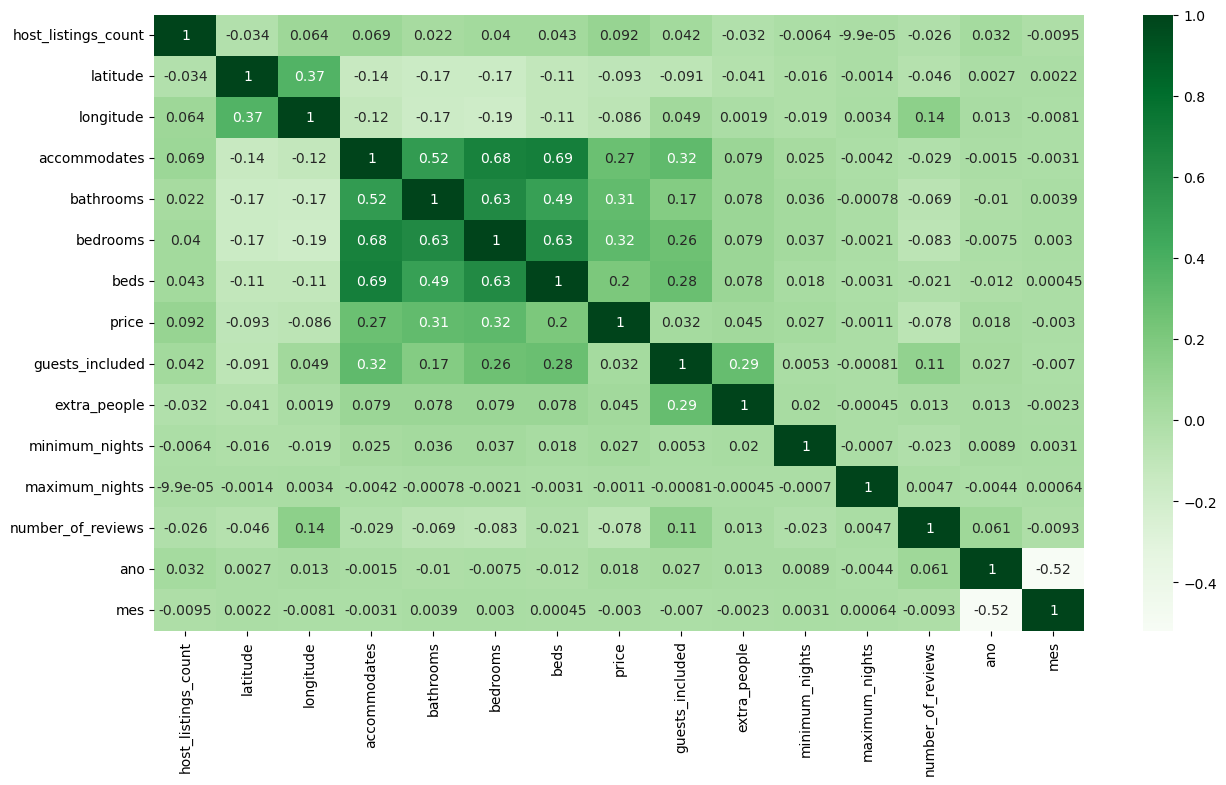

In [10]:
# matriz de correlação
plt.figure(figsize=(15,8))
sns.heatmap(base_arbnb.corr(numeric_only = True), annot = True, cmap = 'Greens')

In [16]:
# Criando função para tratar outliers
def limites(coluna):
    q1 = coluna.quantile(0.25)
    q3 = coluna.quantile(0.75)
    amplitude = q3 - q1
    return q1 - 1.5 * amplitude, q3 + 1.5 * amplitude


In [17]:
limites(base_arbnb['price'])

(-524.0, 1276.0)

In [29]:
# Criando função para gráficos
def diagrama_caixa(coluna):
    fig, (ax1, ax2) = plt.subplots(1,2)
    fig.set_size_inches(15,5)
    sns.boxplot(x = coluna, ax = ax1)
    ax2.set_xlim(limites(coluna))
    sns.boxplot(x = coluna, ax = ax2)
def histograma(coluna):
    plt.figure(figsize = (15,5))
    sns.displot(coluna)
               

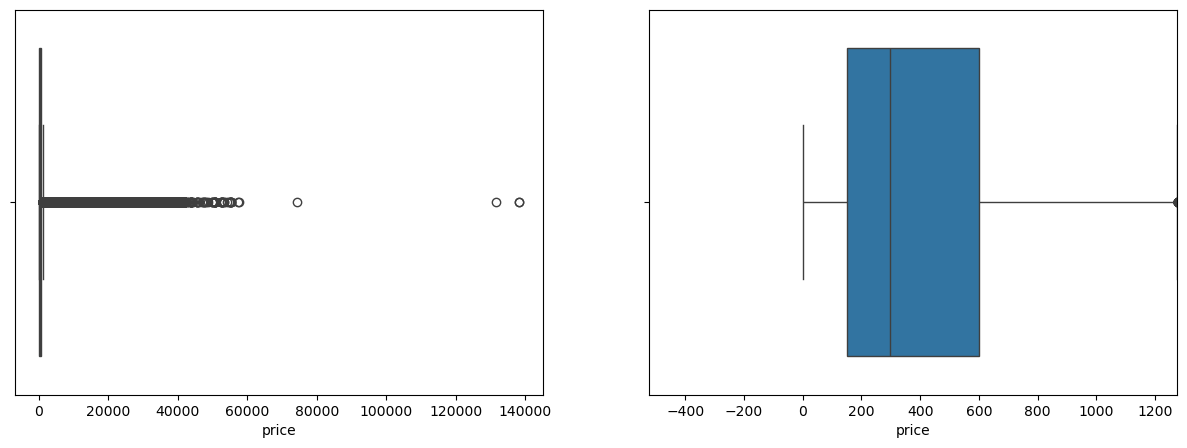

<Figure size 1500x500 with 0 Axes>

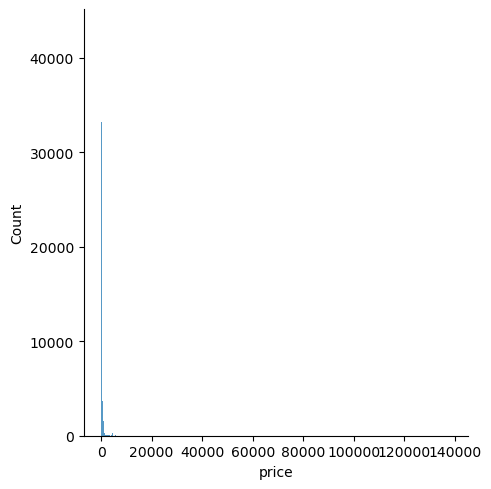

In [31]:
diagrama_caixa(base_arbnb['price'])
histograma(base_arbnb['price'])

### Encoding

### Modelo de Previsão

### Análise do Melhor Modelo

### Ajustes e Melhorias no Melhor Modelo